In [ ]:
%run utils/requirements.py
!pip install pyedflib
!pip install mne

Transaction

  Prefix: /opt/conda

  Updating specs:

   - pytorch-cuda=11.6
   - ca-certificates
   - certifi
   - openssl


  Package                       Version  Build         Channel                    Size
────────────────────────────────────────────────────────────────────────────────────────
  Install:
────────────────────────────────────────────────────────────────────────────────────────

  + cuda                         11.6.1  0             nvidia/linux-64          Cached
  + cuda-cccl                   11.6.55  hf6102b2_0    nvidia/linux-64          Cached
  + cuda-command-line-tools      11.6.2  0             nvidia/linux-64          Cached
  + cuda-compiler                11.6.2  0             nvidia/linux-64          Cached
  + cuda-cudart                 11.6.55  he381448_0    nvidia/linux-64          Cached
  + cuda-cudart-dev             11.6.55  h42ad0f4_0    nvidia/linux-64          Cached
  + cuda-cuobjdump             11.6.124  h2eeebcb_0    nvidia/linux-64     

In [17]:
edf_file_PSG.close()

NameError: name 'edf_file_PSG' is not defined

In [ ]:
"""

create graph is called when we have a time series that needs to be converted into a graph. 
"""
# from utils.get_data import get_Rutgers
from utils.graph_gen import output_append
from utils.util import class_weigth, create_windows
from utils.config_dir import Config
import numpy as np
import os, sys
import pyedflib

def create_graph(Container,key):
    
    global class_weights
    # import warnings
    # warnings.filterwarnings("ignore")

    ##__________________________

    converte = {
        "Sleep stage W" : 0,
        "Sleep stage 1" : 1,
        "Sleep stage 2" : 2,
        "Sleep stage 3" : 3,
        "Sleep stage 4" : 3,
        "Sleep stage R" : 4,
        "Movement time" : 5,
        "Sleep stage ?" : 5
    }
    
    versions = os.listdir("datasets/U-Time/")
    versions.sort()
    
    for version in versions[:5]:
        global X_true
        H_PSG = os.listdir("datasets/U-Time/" + version)
        print(version)
        H_PSG.sort()
        edf_file_path_PSG = "datasets/U-Time/" + version +"/"+ H_PSG[0]
        edf_file_PSG = pyedflib.EdfReader(edf_file_path_PSG)
        num_signals = edf_file_PSG.signals_in_file
        signal_labels = edf_file_PSG.getSignalLabels()

        signals = []
        for i in range(num_signals):
            signal = edf_file_PSG.readSignal(i)
            signals.append(signal)
            
        sample_rate = int(edf_file_PSG.getSignalHeaders()[key]["sample_rate"])
        edf_file_PSG.close()

        edf_file_path_H = "datasets/U-Time/" + version +"/"+ H_PSG[1]
        edf_file_H = pyedflib.EdfReader(edf_file_path_H)
        info=edf_file_H.readAnnotations()
        
        X_mask_markers = info[0]
        X_mask_Labels = info[2]
        for i in range(len(info[2])):
            X_mask_Labels[i] = converte[info[2][i]]
        X_mask_true = []
        
        for i in range(len(X_mask_markers)):
            X_mask_true=np.append(X_mask_true,[X_mask_Labels[i]]*int(info[1][i])*(100 if sample_rate == 3000 else 1)) #*100)

        # X_true = np.stack((signals[3], signals[4], signals[5]),axis=1).reshape(-1,30,3)
        # np.transpose(X_true[0])
        X_true = signals[key].reshape((-1, sample_rate)) #3000
        
        X_mask_true = X_mask_true.reshape((-1,sample_rate))
        Y_true=[]
        for i in range(len(X_true)):
            Y_true=np.append(Y_true,X_mask_true[i][1])
        Y_true=Y_true.astype("int")
        X_mask_true = X_mask_true.astype("int")
        edf_file_H.close()
        ##____________________________________________________
        # print(int(info[1][0]/30), int(info[0][-2]/30))
        output = output_append(GConfig=Container.config["graph"], _X=X_true,X_mask=X_mask_true,Y=Y_true, output=Container.output,start=int(info[1][0]/30),stop=int(info[0][-2]/30))
        Container.change_output(output)
        
    class_weights = class_weigth(Container.config["main"],output)
    Container.weights(class_weights)
    return Container

In [ ]:
import importlib
import utils
from utils.config_dir import Config
importlib.reload(utils.config_dir)
from utils.config_dir import Config
from utils.Models import main
from utils.container import container
import pickle

# Container = container([], Config)
# Container = create_graph(Container,1)
# Container = main(Container)
# Container.dump("my_container0.pickle")

# Container = container([], Config)
# Container = create_graph(Container,2)
# Container = main(Container)
# Container.dump("my_container1.pickle")

Container = container([], Config)
Container = create_graph(Container,0)
Container = main(Container)
Container.dump("my_container0.pickle")

In [ ]:
import importlib
import utils
from utils.config_dir import Config
importlib.reload(utils.config_dir)
from utils.config_dir import Config
from utils.Models import main
from utils.container import container
import pickle

Container = container([], Config)
Container = create_graph(Container,3)
Container = main(Container)
Container.dump("my_container3.pickle")

Container = container([], Config)
Container = create_graph(Container,4)
Container = main(Container)
Container.dump("my_container4.pickle")

In [2]:
from utils.container import container
loaded_container = container(None, None)
loaded_container.load("my_container0.pickle")

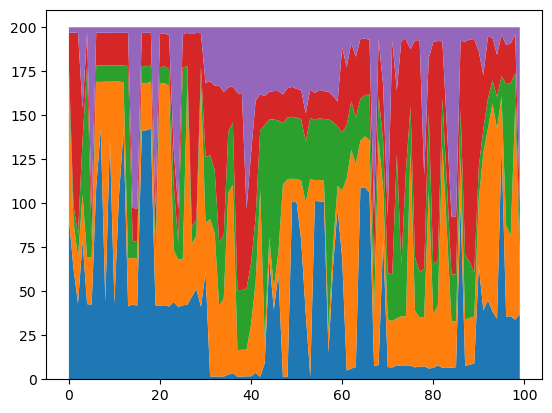

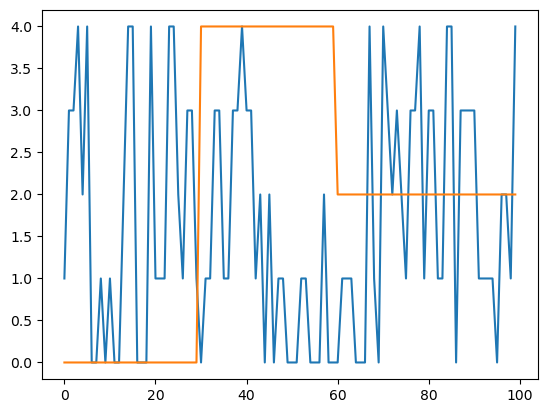

In [13]:
import matplotlib.pyplot as plt
import numpy as np
t=100
# Sample time series data
Data1 = Container1.perc[:t]
Data2 = Container2.perc[:t]

time_points = np.arange(0, len(Data1))  # Numeric values for x-axis
data1 = (np.transpose(Data1)[0] + np.transpose(Data2)[0])
data2 = (np.transpose(Data1)[1] + np.transpose(Data2)[1])
data3 = (np.transpose(Data1)[2] + np.transpose(Data2)[2])
data4 = (np.transpose(Data1)[3] + np.transpose(Data2)[3])
data5 = (np.transpose(Data1)[4] + np.transpose(Data2)[4])

# Calculate percentages
total = [data1[i] + data2[i] for i in range(len(time_points))] # Calculate total for each time point
data1_percentage = [(data1[i]/total[i]) * 100 for i in range(len(time_points))] # Calculate percentage for Time series 1
data2_percentage = [(data2[i]/total[i]) * 100 for i in range(len(time_points))] # Calculate percentage for Time series 2

# Create stacked area chart
plt.stackplot(time_points, data1, data2, data3, data4, data5)
plt.show()
plt.plot(Container1.pred[:t])
plt.plot(Container1.true[:t])